In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# micrograd

In [3]:
class Value:

    ## _children may be used for efficient computation of the gradient
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        ## by default: dosen't do anything
        self._backward = lambda: None
        ## connective tissue of the expression graph
        ## keep pointers about what values produce what other values
        self._prev = set(_children)
        ## record the operation that produced the value
        self._op = _op
        ## store all mathematical expressions by now
        self.label = label

    ## provide a string representation of the object
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        # out = Value(self.data + other.data)
        ## feed in the children of the current value
        out = Value(self.data + other.data, (self, other),'+')
        
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other),'*')
        def _backward():
            ## local derivative: other.data
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1
        
    def __rtruediv__(self, other):
        return other * self**-1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float powers for now"
        out = Value(self.data**other, (self,),f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):

        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self)
        
        self.grad = 1.0
        for node in topo[::-1]:
            node._backward()



In [6]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [11]:
from graphviz import Digraph

## forward: bulid the mathematical expression graph
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    # dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')

    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

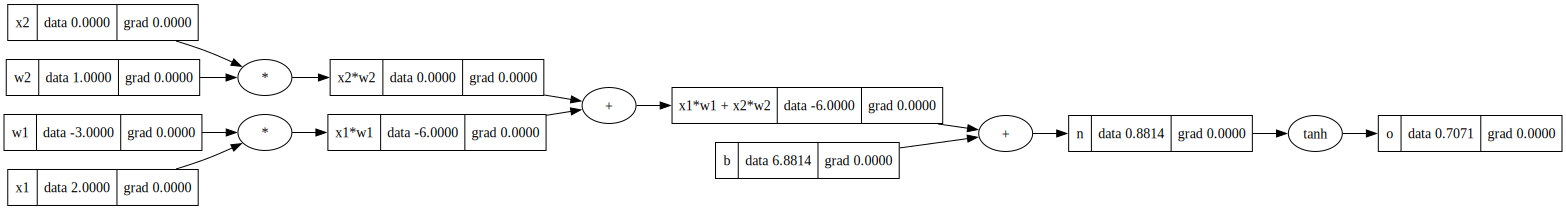

In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
## n: raw activation without activation function
n = x1w1x2w2 + b; n.label = 'n'
## tanh: activation function, hyperbolic function
o = n.tanh(); o.label = 'o'

draw_dot(o)

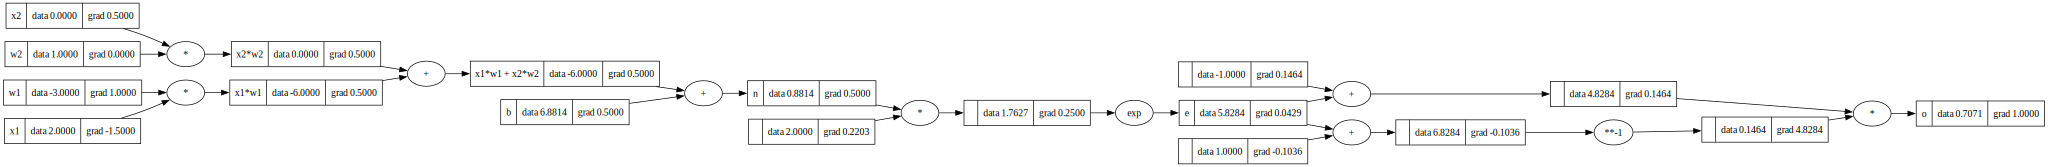

In [11]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
## n: raw activation without activation function
n = x1w1x2w2 + b; n.label = 'n'
## tanh: activation function, hyperbolic function
# o = n.tanh(); o.label = 'o'
# ---- broke up tanh into two steps
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1); o.label = 'o'
# ----
o.backward()
draw_dot(o)

# pytorch

In [13]:
import torch
## tensor: multiple sclalar values in list

In [14]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [15]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [18]:
## tensor work on all process in parallel
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [17]:
o.item()

0.7071066904050358

# Neuron
<img src='images/cnn.jpeg'>

In [106]:

# random.seed(230)
from typing import Any


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)) , self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
            
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x) -> Any:
        for layer in self.layers:
            x=layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    
# x =[2.0, 3.0]
# # n = Neuron(2)
# n = Layer(2,3)
# n(x)
    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1]) # 4 neuron layer1, 4 neuron layer2, 1 neuron output layer
n(x)

Value(data=-0.03885172301335757)

In [107]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [143]:
for k in range(20):

    ## forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

    ## backward pass
    for p in n.parameters():
        ## set grad to zero, as grad is accumilated +=
        ## bug that misses this step: cause problem when nn gets more compelex
        ## make the optimiaztion worse
        p.grad = 0.0
    loss.backward()

    ## update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.0009024449395842695
1 0.0009009731174860541
2 0.0008995059294909516
3 0.000898043354005573
4 0.000896585369569683
5 0.0008951319548551381
6 0.0008936830886649002
7 0.0008922387499320224
8 0.0008907989177186857
9 0.0008893635712151837
10 0.0008879326897389412
11 0.000886506252733584
12 0.0008850842397679694
13 0.0008836666305352054
14 0.0008822534048517613
15 0.0008808445426564849
16 0.0008794400240097189
17 0.0008780398290923973
18 0.000876643938205066
19 0.000875252331767068


In [103]:
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))


Value(data=4.5474186828421215e-05)

In [101]:
loss.backward()

In [102]:
for p in n.parameters():
    p.data += -0.1 * p.grad

In [142]:
ypred

[Value(data=0.9866940268963993),
 Value(data=-0.9873014181134823),
 Value(data=-0.9823166874350429),
 Value(data=0.9840965735741999)]